In [9]:
#  Section 1: Imports and Setup
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from pyswarm import pso
from dotenv import load_dotenv
from openai import OpenAI

#  Section 2: Load API Key
load_dotenv("OPENAI_API_KEY.env")
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

#  Section 3: Load and Prepare Dataset
df = pd.read_excel("default of credit card clients.xls", header=1)
X = df.drop(columns=["ID", "default payment next month"]).values
y = df["default payment next month"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

#  Section 4: Define MLP Model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 2)
        )
    def forward(self, x):
        return self.net(x)
        
# Section 5: PSO Evaluation Function with EarlyStopping
def run_pso_with_bounds(lb, ub, particles=10, iterations=10):
    history = []

    def eval_fn(params):
        hidden = int(params[0])
        lr = params[1]
        dropout = params[2]
        l2 = params[3]

        model = MLP(23, hidden, dropout)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)

        best_auc = -np.inf
        no_improve = 0
        patience = 3
        best_state = None

        for epoch in range(20):
            model.train()
            optimizer.zero_grad()
            loss = criterion(model(X_train), y_train)
            loss.backward()
            optimizer.step()

            model.eval()
            with torch.no_grad():
                probs = torch.softmax(model(X_val), dim=1)[:, 1].numpy()
                val_auc = roc_auc_score(y_val.numpy(), probs)

            if val_auc > best_auc + 1e-4:
                best_auc = val_auc
                best_state = model.state_dict()
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    break

        history.append({"hidden": hidden, "lr": lr, "dropout": dropout, "l2": l2, "auc": best_auc})
        return -best_auc

    pso(eval_fn, lb, ub, swarmsize=particles, maxiter=iterations)
    return history

# Section 5: PSO Optimization Function (fixed swarmsize & maxiter, meta-params are tunable)
def run_pso_with_meta(lb, ub, inertia_weight, cognitive_coeff, social_coeff, particles=10, iterations=10):
    history = []

    def eval_fn(params):
        hidden = int(params[0])
        lr = params[1]
        dropout = params[2]
        l2 = params[3]

        model = MLP(23, hidden, dropout)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)

        best_auc = -np.inf
        no_improve = 0
        patience = 3
        best_state = None

        for epoch in range(20):
            model.train()
            optimizer.zero_grad()
            loss = criterion(model(X_train), y_train)
            loss.backward()
            optimizer.step()

            model.eval()
            with torch.no_grad():
                probs = torch.softmax(model(X_val), dim=1)[:, 1].numpy()
                val_auc = roc_auc_score(y_val.numpy(), probs)

            if val_auc > best_auc + 1e-4:
                best_auc = val_auc
                best_state = model.state_dict()
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    break

        history.append({
            "hidden": hidden,
            "lr": lr,
            "dropout": dropout,
            "l2": l2,
            "auc": best_auc
        })
        return -best_auc

    pso(eval_fn, lb, ub, swarmsize=particles, maxiter=iterations,
        omega=inertia_weight, phip=cognitive_coeff, phig=social_coeff)
    return history

def build_prompt_for_meta_config(history, round_id):
    prompt = f"You are helping optimize the PSO algorithm's meta-parameters (NOT MLP hyperparameters). This is round {round_id}."

    prompt += "\n\nHere are the top configurations from the last PSO run and their validation AUCs:\n"
    top = sorted(history, key=lambda x: -x["auc"])[:10]
    for i, row in enumerate(top):
        prompt += f"#{i+1}: hidden={row['hidden']}, lr={row['lr']:.5f}, dropout={row['dropout']:.2f}, l2={row['l2']:.5f}, AUC={row['auc']:.4f}\n"

    prompt += """
Now recommend the following PSO meta-parameters:
- inertia_weight (float between 0.1 and 1.2)
- cognitive_coeff (float between 0.5 and 2.5)
- social_coeff (float between 0.5 and 2.5)

Respond only in JSON:
{
  "inertia_weight": float,
  "cognitive_coeff": float,
  "social_coeff": float,
  "reason": "..."
}
"""
    return prompt


# Section 7: GPT 
def call_gpt_for_meta_config(prompt, round_id):
    print(f"===== GPT Prompt (Round {round_id}) =====")
    print(prompt)

    response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a PSO meta-parameter tuning assistant."},
            {"role": "user", "content": prompt}
        ]
    )

    msg = response.choices[0].message.content

    print(f"===== GPT Response (Round {round_id}) =====")
    print(msg)

    # save
    with open(f"meta_response_round_{round_id}.json", "w") as f:
        f.write(msg)

    return json.loads(msg)

# Section 8: Two rounds of comparison (default vs GPT guidance)
def run_two_round_meta_guided_pso():
    bounds = {
        "hidden": [20, 200],
        "lr": [0.0001, 0.01],
        "dropout": [0.1, 0.5],
        "l2": [0.00001, 0.01]
    }

    swarmsize = 10
    maxiter = 10

    # Round 1 - Default PSO meta parameter
    print("\\n[Round 1] Default PSO Meta-Parameters")
    history1 = run_pso_with_meta(
        [bounds["hidden"][0], bounds["lr"][0], bounds["dropout"][0], bounds["l2"][0]],
        [bounds["hidden"][1], bounds["lr"][1], bounds["dropout"][1], bounds["l2"][1]],
        inertia_weight=0.5,
        cognitive_coeff=1.0,
        social_coeff=1.0,
        particles=swarmsize,
        iterations=maxiter
    )
    best1 = max(history1, key=lambda x: x["auc"])

    # Round 2 - meta parameters for GPT guidance
    prompt = build_prompt_for_meta_config(history1, round_id=1)
    gpt_config = call_gpt_for_meta_config(prompt, round_id=1)

    print(f"\\n[Round 2] GPT Suggested Meta-Parameters: w={gpt_config['inertia_weight']}, c1={gpt_config['cognitive_coeff']}, c2={gpt_config['social_coeff']}")
    print("Reason:", gpt_config["reason"])

    history2 = run_pso_with_meta(
        [bounds["hidden"][0], bounds["lr"][0], bounds["dropout"][0], bounds["l2"][0]],
        [bounds["hidden"][1], bounds["lr"][1], bounds["dropout"][1], bounds["l2"][1]],
        inertia_weight=gpt_config["inertia_weight"],
        cognitive_coeff=gpt_config["cognitive_coeff"],
        social_coeff=gpt_config["social_coeff"],
        particles=swarmsize,
        iterations=maxiter
    )
    best2 = max(history2, key=lambda x: x["auc"])

    if best2["auc"] > best1["auc"]:
        print(f"\\n✅ Final result selected from GPT meta-config (AUC = {best2['auc']:.4f})")
        return [history1, history2], best2
    else:
        print(f"\\n✅ Final result selected from default meta-config (AUC = {best1['auc']:.4f})")
        return [history1, history2], best1

# Section 9: Visualize AUC trend per iteration for each PSO round
def plot_auc_per_iteration(history_list):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(8, 5))
    for idx, history in enumerate(history_list):
        aucs = [x["auc"] for x in history]
        ax.plot(range(1, len(aucs)+1), aucs, label=f"Round {idx+1}")

    ax.set_xlabel("PSO Iteration (Particle Index)")
    ax.set_ylabel("Validation AUC")
    ax.set_title("AUC per Iteration in Each PSO Round")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# Section 10: Evaluate final best model on test set
def evaluate_on_test_set(best_result):
    model = MLP(23, best_result['hidden'], best_result['dropout'])
    optimizer = optim.Adam(model.parameters(), lr=best_result['lr'], weight_decay=best_result['l2'])
    criterion = nn.CrossEntropyLoss()

    best_auc = -np.inf
    no_improve = 0
    patience = 5
    best_state = None

    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        loss = criterion(model(X_train), y_train)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            probs = torch.softmax(model(X_val), dim=1)[:, 1].numpy()
            val_auc = roc_auc_score(y_val.numpy(), probs)

        if val_auc > best_auc + 1e-4:
            best_auc = val_auc
            best_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                break

    # Load the best model and evaluate on test set
    model.load_state_dict(best_state)
    model.eval()
    with torch.no_grad():
        probs = torch.softmax(model(X_test), dim=1)[:, 1].numpy()
        test_auc = roc_auc_score(y_test.numpy(), probs)

    print(f"\\nFinal Test AUC (based on best validation model): {test_auc:.4f}")

# Section 11: Export PSO optimization history to CSV
def export_results(all_rounds, filename="pso_result_export.csv"):
    flat = [{**res, "round": r+1} for r, round in enumerate(all_rounds) for res in round]
    df = pd.DataFrame(flat)
    df.to_csv(filename, index=False)
    print(f"\\nExported PSO history to: {filename}")
    return df


\n[Round 1] Default PSO Meta-Parameters
Stopping search: maximum iterations reached --> 10
===== GPT Prompt (Round 1) =====
You are helping optimize the PSO algorithm's meta-parameters (NOT MLP hyperparameters). This is round 1.

Here are the top configurations from the last PSO run and their validation AUCs:
#1: hidden=97, lr=0.00985, dropout=0.10, l2=0.00128, AUC=0.7357
#2: hidden=97, lr=0.00997, dropout=0.10, l2=0.00126, AUC=0.7317
#3: hidden=107, lr=0.00982, dropout=0.10, l2=0.00001, AUC=0.7313
#4: hidden=92, lr=0.01000, dropout=0.10, l2=0.00072, AUC=0.7308
#5: hidden=74, lr=0.00995, dropout=0.12, l2=0.00123, AUC=0.7307
#6: hidden=108, lr=0.00948, dropout=0.20, l2=0.00383, AUC=0.7306
#7: hidden=89, lr=0.00995, dropout=0.11, l2=0.00083, AUC=0.7305
#8: hidden=103, lr=0.00993, dropout=0.10, l2=0.00147, AUC=0.7305
#9: hidden=77, lr=0.01000, dropout=0.11, l2=0.00360, AUC=0.7291
#10: hidden=109, lr=0.01000, dropout=0.10, l2=0.00150, AUC=0.7290

Now recommend the following PSO meta-parame

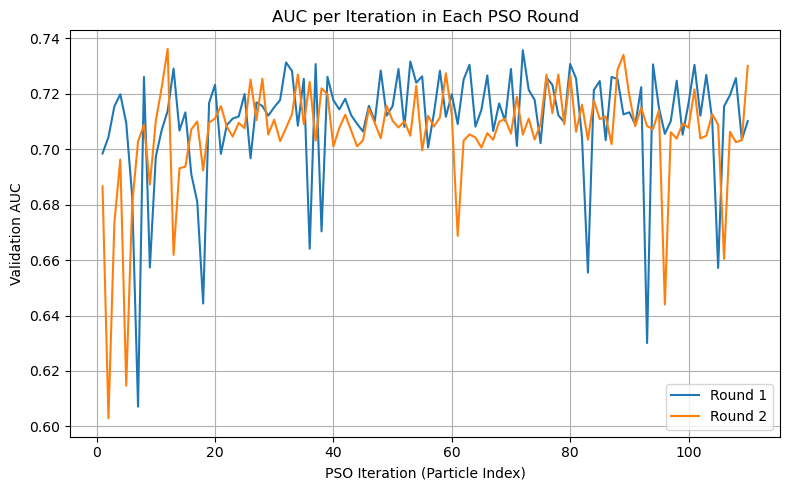

\nFinal Test AUC (based on best validation model): 0.7747
\nExported PSO history to: pso_meta_guided_results.csv


,hidden,lr,dropout,l2,auc,round
0,157,0.008812,0.381797,0.007672,0.698483,1
1,198,0.004964,0.318012,0.007713,0.704410,1
2,105,0.009551,0.111348,0.005922,0.715470,1
3,130,0.007636,0.474312,0.009261,0.719855,1
4,152,0.009994,0.449458,0.003509,0.709542,1
...,...,...,...,...,...,...
215,101,0.008315,0.247761,0.001626,0.660460,2
216,147,0.008750,0.126160,0.000919,0.706302,2
217,162,0.008351,0.500000,0.002395,0.702556,2
218,152,0.009334,0.238319,0.002032,0.703285,2


In [11]:
# === Main Execution ===

# Step 1: Run 2 rounds of PSO
# - Round 1 uses default meta-parameters
# - Round 2 uses GPT-suggested meta-parameters
all_histories, best_result = run_two_round_meta_guided_pso()

# Step 2: Visualize AUC progression
plot_auc_per_iteration(all_histories)

# Step 3: Evaluate final selected model on test set
evaluate_on_test_set(best_result)

# Step 4: Export all PSO results to CSV for reporting
export_results(all_histories, filename="pso_meta_guided_results.csv")
